# Прогнозирование вероятности оттока пользователей для фитнес-центров

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. 

**Цель исследования:** 

Провести анализ и подготовить план действий по удержанию клиентов. 
А именно:

- Научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- Проанализировать основные признаки, наиболее сильно влияющие на отток;
- Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    - 1) Выделить целевые группы клиентов;
    - 2) Предложить меры по снижению оттока;
    - 3) Определить другие особенности взаимодействия с клиентами.


## 1. Загрузка данных

In [1]:
# Импортирую библиотеки
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Загружу таблицы
try:
    df = pd.read_csv('gym_churn.csv')
except: 
    df = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
# Выведу таблицу
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


«Культурист-датасаентист» предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:

Данные клиента за предыдущий до проверки факта оттока месяц:

- `gender` — пол;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент  в таком случае фитнес-центр хранит информацию о работодателе клиента);
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- `Phone` — наличие контактного телефона;
- `Age` — возраст;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

- `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Group_visits` — факт посещения групповых занятий;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- `Churn` — факт оттока в текущем месяце.


---

## 2. Исследовательский анализ данных (EDA)

In [4]:
# Посмотрю информацию по таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Таблица состоит из 14 столбцов и 4000 строк. Пропусков в данных нет.

Заменю тип данных в столбце `month_to_end_contract` на int

In [5]:
# Приведу названия столбцов к нижнему регистру
df.columns = df.columns.str.lower()

In [6]:
# Проверю значения в столбце 'month_to_end_contract'
df['month_to_end_contract'].value_counts()

1.0     2207
6.0      645
12.0     524
11.0     181
5.0      130
10.0      82
9.0       73
4.0       58
8.0       38
7.0       25
3.0       23
2.0       14
Name: month_to_end_contract, dtype: int64

In [7]:
# Заменю тип данных
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int64  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

In [8]:
# Проверю данные на наличие явных дубликатов
print('Количество добликатов: ', df.duplicated().sum())

Количество добликатов:  0


### Расмотреть средние значения и стандартные отклонения с помощью метода `describe`

In [9]:
# Выведу на экран статистику по таблице
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


- `gender` - 51%, примерно равное распределение клиентов мужского и женского пола.
- `near_location` - 84% - большая часть клиентов живет или работает в районе, где находится фитнес-клуб.
- `partner` - 48% - половина клиентов это сотрудники организаций партнёров и просто работники данного фитнес-клуба. 
- `promo_friends` - 31% стали клиентами в рамках акции «приведи друга».
- `phone` - 90% - большая часть клиентов указали телефон при покупке абонемента.
- `contract_period` - 4,7 мес - среднее значение длительности абонемента. Т.к. абонемента с такой продолжительности нет, предположу, что чаще покупают на 6 мес.
- `group_visits` - 41% клиентов посещают групповые занятия. 
- `age` - 29 лет - средний возраст клиентов
- `avg_additional_charges_total` - 147 руб выручка от сопутствующих продаж фитнес-клуба.
- `month_to_end_contract` - 4,3 мес в среднем осталось до окончания действия абонемента.
- `lifetime` - 3,7 мес в среднем прошло с первого посещения фитнес центра.
- `avg_class_frequency_total` - примерно 2 посещения в неделю с начала действия абонемента.
- `avg_class_frequency_current_month` - примерно 2 посещения в неделю за предыдущий месяц.
- `churn` - 26% доля оттока.

### Расмотреть средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [10]:
churn = df.groupby('churn').mean()
churn = churn.T
churn.columns = ['Клиенты', 'Бывшие клиенты']
churn

,Клиенты,Бывшие клиенты
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


- Чаще остаются клиенты, которые живут/работают рядом с фитнес-клубом;
- Удержание клиентов выше, если они попали в фитнес-клуб по партнёрской программе;
- Те клиенты, которые пришли по акции «приведи друга» остаются чаще;
- Посещение групповых занятий влияет на удержание;
- Выручка с сопутствующих продаж больше от клиентов, которые не перестали посещать фитнес-клуб;
- Клиенты, которые покупают абонементы на 6 мес и год, реже уходят;
- Время с момента первого посещения постоянного клиента - 5 мес, а ушедших клиентов - 1 мес. Соответственно, нужно заниматься удержанием новых клиентов;
- Среди клиентов, которые остались, число посещений больше, чем у ушедших;
- В последний месяц у ушедших клиентов посещаемость ниже. 

Не влияет на удержание следующие признаки: 
- Пол клиента;
- Наличие телефона клиента в базе;
- Возраст клиента.

### Построить столбчатые гистограммы и распределения признаков для тех, кто ушёл и тех, кто остался

In [11]:
# Задам значение тех что ущёл  и остался 
churn_1 = df.query('churn == 1')
churn_0 = df.query('churn == 0')

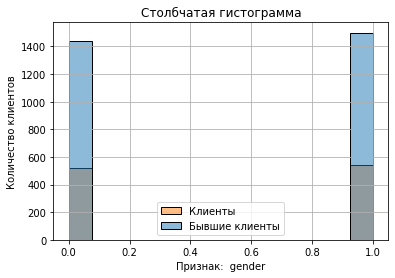

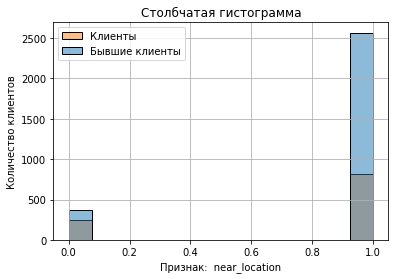

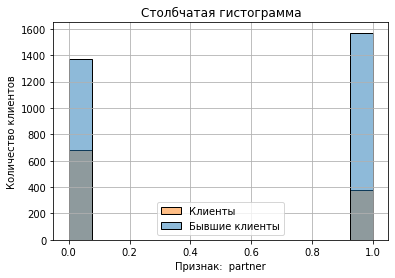

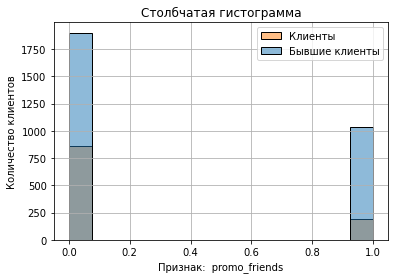

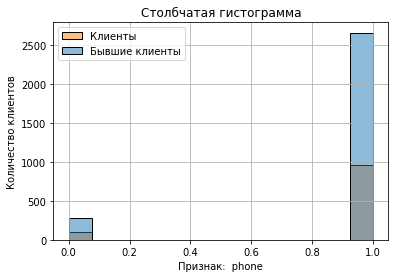

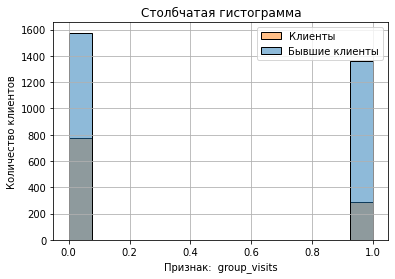

In [12]:
# переменная с столбцами с булевыми значениями 
bull = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']

for col in bull:
    sns.histplot(data=df, x=col, hue='churn')
    plt.title(f'Столбчатая гистограмма')
    plt.xlabel(f'Признак:  {col}')
    plt.ylabel('Количество клиентов')
    plt.legend(labels=['Клиенты', 'Бывшие клиенты'])
    plt.grid()
    plt.show()

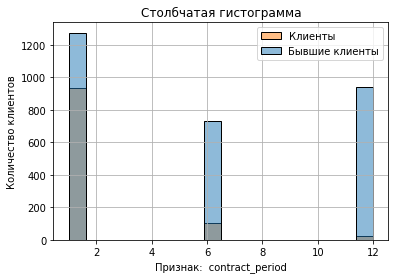

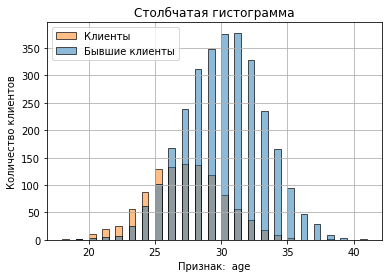

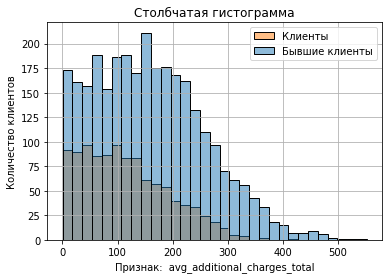

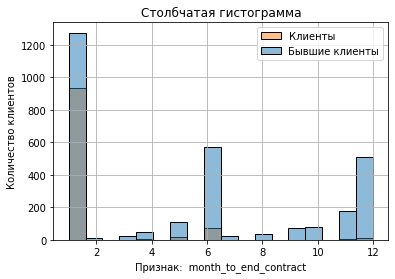

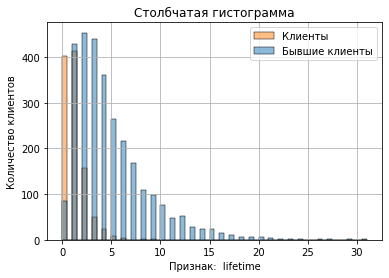

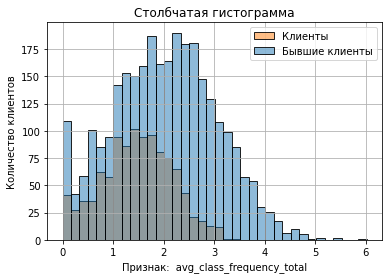

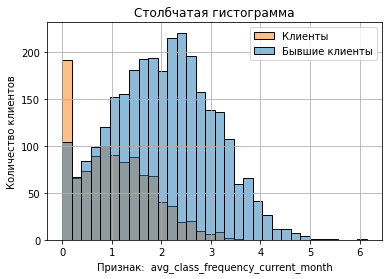

In [13]:
# переменная с численными значениями
integ = ['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 
       'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']

for col in integ:
    sns.histplot(data=df, x=col, hue='churn')
    plt.title(f'Столбчатая гистограмма')
    plt.xlabel(f'Признак:  {col}')
    plt.ylabel('Количество клиентов')
    plt.legend(labels=['Клиенты', 'Бывшие клиенты'])
    plt.grid()
    plt.show()

### Построить матрицу корреляций

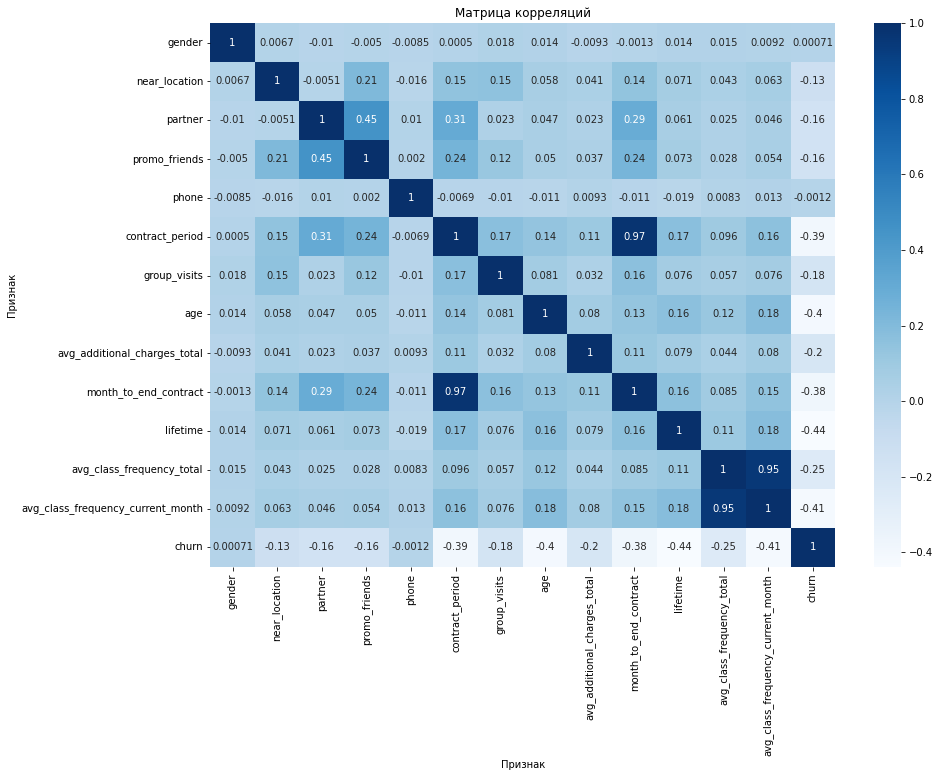

In [14]:
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), annot = True, cmap='Blues')
plt.title(f'Матрица корреляций')
plt.xlabel('Признак')
plt.ylabel('Признак')
plt.show()

На матрице корреляции видно две зависимости: 
- Срок до окончания текущего действующего абонемента (month_to_end_contract) и длительность текущего абонемента (contract_period)
- Средняя частота посещений в неделю за все время с начала действия абонемента; (avg_class_frequency_total) и средняя частота посещений в неделю за предыдущий месяц (avg_class_frequency_current_month)

____

##  3. Исследование моделей прогнозирования оттока клиентов

In [15]:
# Выделю признаки
X = df.drop('churn', axis=1)
y = df['churn']

In [16]:
# Разделю данные на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [17]:
print('------------------------------')
print(f'Размер обучающей выборки: {X_train.shape[0]/len(df):.0%}')
print(f'Размер тестовой выборки: {X_test.shape[0]/len(df):.0%}')
print('------------------------------')

------------------------------
Размер обучающей выборки: 80%
Размер тестовой выборки: 20%
------------------------------


In [18]:
# стандартизируем данные 
scaler = StandardScaler()
scaler.fit(X_train)

X_train_st = scaler.transform(X_train) 
X_test_st = scaler.transform(X_test) 

#### LogisticRegression

In [19]:
%%time 

model_lr = LogisticRegression(random_state=0)
model_lr.fit(X_train_st, y_train)
pred_lr = model_lr.predict(X_test_st)

print('---Линейная регрессия---')
print('Accuracy:', round(accuracy_score(y_test, pred_lr), 3))
print('Precision:', round(precision_score(y_test, pred_lr), 3))
print('Recall:', round(recall_score(y_test, pred_lr), 3))
print('--------------------------------------------------')

---Линейная регрессия---
Accuracy: 0.922
Precision: 0.854
Recall: 0.828
--------------------------------------------------
CPU times: user 0 ns, sys: 109 ms, total: 109 ms
Wall time: 22.4 ms


#### RandomForestClassifier

In [ ]:
%%time 

model_rfc = RandomForestClassifier(random_state=0)
param_rfc = {'max_depth': range (1, 20), 'n_estimators': range(50, 110)}

model_rfc = GridSearchCV(model_rfc, param_grid=param_rfc, cv=5)
model_rfc.fit(X_train_st, y_train)
print('Лучшие параметры:', model_rfc.best_params_)

In [ ]:
%%time 

model_rfc = RandomForestClassifier(random_state=0, max_depth = 19, n_estimators=101)
model_rfc.fit(X_train_st, y_train)
pred_rfc = model_rfc.predict(X_test_st)

print('---Случайный лес---')
print('Accuracy:', round(accuracy_score(y_test, pred_rfc), 3))
print('Precision:', round(precision_score(y_test, pred_rfc), 3))
print('Recall:', round(recall_score(y_test, pred_rfc), 3))
print('--------------------------------------------------')

**Вывод**

- Доля правильных ответов **accuracy** выше у модели `LogisticRegression`- 0.922 (`RandomForestClassifier` - 0.916);
- Точность **precision** выше у модели `LogisticRegression`- 0.854 (`RandomForestClassifier` - 0.839);
- Полнота данных **recall** больше у модели `LogisticRegression`- 0.828 (`RandomForestClassifier` - 0.818).

Обе модели показали себя хорошо, но с небольшим отрывом результат метрик `LogisticRegression` после обучения - лучше.
Модель `LogisticRegression` больше подойдёт для прогнозирования оттока клиентов.

____

## 4. Кластеризация клиентов фитнес-центра

In [ ]:
# стандартизируем данные 
X_sc = scaler.fit_transform(X)
linked = linkage(X_sc, method = 'ward') 

### Построить дендрограмму

In [ ]:
%%time 

# Отображу дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма кластеризации клиентов фитнес-центра')
plt.show() 

Судя по дендограмме оптимальное число кластеров - **5**

### Обучить модель кластеризации на основании алгоритма K-Means и спрогнозировать кластеры клиентов 

In [ ]:
# задам модель k_means с числом кластеров 5
km = KMeans(n_clusters = 5, random_state = 0)

# прогнозирую кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(X_sc)

# сохраню метки кластера в поле нашего датасета
df['cluster_km'] = labels

# Выведу среднее значение для кластеров
display(df.groupby(['cluster_km']).mean().T)

# Рассчитаю количество ушедших клиентов и долю оттока
leav_club = df.query('churn == 1').groupby('cluster_km').agg({'churn':'count'}).reset_index()
leav_club['%'] = leav_club['churn'] / (leav_club['churn'].sum()) * 100

display(leav_club.T)

___

**Кластер 0**
- Работают/живут недалеко от фитнес-клуба - 95%;
- Занимаются по программе лояльности - 78%;
- Клиенты данного кластера чаще приходят по акции «приведи друга» - 57% (возможно сами приводят друзей по данной программе);
- Чаще покупают абонемент длительностью - 1 год;
- Чаще посещают групповые занятия - 54%;
- С данных клиентов больше выручка с сопутствующих продаж - 160 руб;
- Посещают фитнес-клуб примерно 2 раза в неделю;
- **Отток 2%**
___

**Кластер 1**
- Работают/живут недалеко от фитнес-клуба - 86%;
- 47% занимаются по программе лояльности;
- 30% пришли по акции «приведи друга»;
- Чаще не указывают номер телефона;
- Абонемент в среднем на 4,7 мес
- 42% посещают групповые занятия;
- Доход с сопутствующих продаж ~143 руб;
- Посещают фитнес-клуб примерно 2 раза в неделю;
- **Отток 26%**

____
**Кластер 2**
- Клиенты живут/работают очень далеко от фитнес-клуба;
- 46% занимаются по программе лояльности;
- всего 8% пришли по акции «приведи друга»;
- Абонемент в среднем 2,3 мес;
- 21% посещают групповые занятия;
- Доход с сопутствующих продаж ~135 руб;
- Посещают фитнес-клуб в среднем 1,5 раза в неделю;
- **Отток 44%**
____
**Кластер 3**
- 100% проживают/работают рядом с фитнес-клубом;
- 35% занимаются по программе лояльности;
- 24% пришли по акции «приведи друга»;
- Абонемент в среднем на 1,9 мес;
- 34% посещают групповые занятия;
- Доход с сопутствующих продаж ~131 руб;
- Посещают фитнес-клуб примерно 1 раза в неделю;
- **Отток 51%**
____
**Кластер 4**
- Работают/живут недалеко от фитнес-клуба - 97%;
- 35% занимаются по программе лояльности;
- 23% пришли по акции «приведи друга»;
- Абонемент в среднем на 2,6 мес;
- 47% посещают групповые занятия;
- Доход с сопутствующих продаж ~161 руб;
- Посещают фитнес-клуб примерно 3 раза в неделю;
- **Отток 6%**

____

### Построить распределения признаков для кластеров

In [ ]:
df_cl= df.groupby(['cluster_km', 'churn']).mean().reset_index()

bull = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']

for col in bull:
    sns.barplot(data=df_cl, x='cluster_km', y=col, hue='churn', palette='Blues')
    plt.title(f'Столбчатая гистограмма')
    plt.xlabel(f'Признак:  {col}')
    plt.ylabel('Количество клиентов')
    plt.grid()
    plt.show()

In [ ]:
# переменная с численными значениями
integ = ['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 
       'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']

for col in integ:
    sns.displot(data=df, x=col, hue='cluster_km', kind='hist', height=5, aspect=1.2, palette='mako')
    plt.title(f'Столбчатая гистограмма')
    plt.xlabel(f'Признак:  {col}')
    plt.ylabel('Количество клиентов')
    plt.grid()
    plt.show()

После исследования выделю два кластера с наибольшим оттоком: 2 и 3

Для этих кластеров характерно: 
- Чаще всех приобретает абонемент на короткий срок - 1 мес;
- Мало посещают групповые занятия;
- Реже приходят в клуб по акции «приведи друга»;
- Посещают клуб меньше 2 раз в неделю

## Посчитать долю оттока 

In [ ]:
df.groupby(['cluster_km'])['churn'].sum()/(df.groupby(['cluster_km'])['churn'].count()) * 100

## 5. Общие выводы

1. В ходе исследования загрузили данные таблицы gym_churn и подготовили их к анализу, сделав следующее: 

    - Привели названия столбцов к нижнему регистру;
    - Заменили тип данных в столбце 'month_to_end_contract' на int;
    - Проверили данные на наличие явных дубликатов и пропусков
    
2. Провели исследовательский анализ данных (EDA)

    - Изучили средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался;
    - Построили столбчатые гистограммы и распределения признаков для тех, кто ушёл и тех, кто остался;
    - Построили матрицу корреляций и отобразили её.
    
    
3. Обучить модели `LogisticRegression` и `RandomForestClassifier` для прогнозирования оттока клиентов, используя следующие метрики  *accuracy*, *precision* и *recall*: 

`LogisticRegression`

    - Accuracy: 0.922
    - Precision: 0.854
    - Recall: 0.828

`RandomForestClassifier`

    - Accuracy: 0.916
    - Precision: 0.839
    - Recall: 0.818

Обе модели показали себя хорошо, но с небольшим отрывом результат метрик LogisticRegression после обучения - лучше. Модель LogisticRegression больше подойдёт для прогнозирования оттока клиентов.

4. Провели кластеризацию клиентов

Обучили  модель кластеризации на основании алгоритма K-Means и выявили 5 основных кластеров клиентов:

**Кластер 0**
- Работают/живут недалеко от фитнес-клуба - 95%;
- Занимаются по по программе лояльности - 78%;
- Клиенты данного кластера чаще приходят по акции «приведи друга» - 57% (возможно сами приводят друзей по данной программе);
- Чаще покупают абонемент длительностью - 1 год;
- Чаще посещают групповые занятия - 54%;
- С данных клиентов больше выручка с сопутствующих продаж - 160 руб;
- Посещают фитнес-клуб примерно 2 раза в неделю;
- **Отток 2%**

**Кластер 1**
- Работают/живут недалеко от фитнес-клуба - 86%;
- 47% занимаются по программе лояльности;
- 30% пришли по акции «приведи друга»;
- Чаще не указывают номер телефона;
- Абонемент в среднем на 4,7 мес
- 42% посещают групповые занятия;
- Доход с сопутствующих продаж ~143 руб;
- Посещают фитнес-клуб примерно 2 раза в неделю;
- **Отток 26%**

**Кластер 2**
- Клиенты живут/работают очень далеко от фитнес-клуба;
- 46% занимаются по программе лояльности;
- всего 8% пришли по акции «приведи друга»;
- Абонемент в среднем 2,3 мес;
- 21% посещают групповые занятия;
- Доход с сопутствующих продаж ~135 руб;
- Посещают фитнес-клуб в среднем 1,5 раза в неделю;
- **Отток 44%**

**Кластер 3**
- 100% проживают/работают рядом с фитнес-клубом;
- 35% занимаются по программе лояльности;
- 24% пришли по акции «приведи друга»;
- Абонемент в среднем на 1,9 мес;
- 34% посещают групповые занятия;
- Доход с сопутствующих продаж ~131 руб;
- Посещают фитнес-клуб примерно 1 раза в неделю;
- **Отток 51%**

**Кластер 4**
- Работают/живут недалеко от фитнес-клуба - 97%;
- 35% занимаются по программе лояльности;
- 23% пришли по акции «приведи друга»;
- Абонемент в среднем на 2,6 мес;
- 47% посещают групповые занятия;
- Доход с сопутствующих продаж ~161 руб;
- Посещают фитнес-клуб примерно 3 раза в неделю;
- **Отток 6%**
___

🔴После исследования выделим два кластера с наибольшим оттоком: 2 и 3🔴

Для этих кластеров характерно: 
- Чаще всех приобретает абонемент на короткий срок - 1 мес;
- Мало посещают групповые занятия;
- Реже приходят в клуб по акции «приведи друга»;
- Посещают клуб меньше 2 раз в неделю

🟢Так же обозначу характеристика кластеров 0 и 4, где удержание клиентов выше:🟢
- Проживают/работают рядом с фитнес-клубом;
- Клиент занимается по программе лояльности;
- Преобретают абонементы длительностью от 6 мес включительно;
- Часто посещают групповые занятия;
- Ходят на тренировку 2-3 раза в неделю

## Рекомендации

- Предлагать новым клиентам скидки на абонементы длительностью 6 и 12 мес (т.к. они стоят на порядок дороже абонемента на 1 мес, потраченные деньги станут дополнительным стимулом для посещения зала);


- Создать систему бонусов за посещение зала для дополнительной мотивации. Например, за одно посещение начислять баллы на счет клиента для приобретения сопутствующих товаров в фитнес-клубе: спортпит, несколько походов в солярий и т.д.;


- Подумать над увеличением количества организаций-партнёров, т.к. удержание и отдача клиентов, которые приходят по этой программе крайне положительные;


- Изучить вопрос, "Почему бывшие клиенты редко посещали групповые занятия?". Возможно дело в цене за посещение, малом разнообразии типов групповых занятий или времени в котором они проходят;


- Среди тех, кто приходят в клуб по акции «приведи друга» - хорошая динамика. Стоит попытаться разработать программу вознаграждения для тех, кто приводит друзей в зал (Допустим клиент получает денежное вознаграждение за то что привёл друга в 1000р или дополнительный 1 мес. занятий), думаю, что это положительно повлияет на удержание.


На примере исследования прослеживается самая подверженная оттокам группа - новички, те, кто приобретает абонемент на 1 мес. Необходимо стимулировать данных клиентов дополнительными скидками, акциями, бонусами. Не стоит так же забывать клиентов, которые давно посещают зал.